# Hidden Markov Models

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo
import scipy.special as scsp

import matplotlib.pyplot as plt
import seaborn as sns

# custom library with some pre-coded functions
import hmm_library as hmmlib

## Tutorial content

1. We will study the generative model of a hidden Markov model and simulate data
2. We will see how the EM algorithm can be employed for Hidden Markov models

*Note*: You can find many parts of the code pre-coded in the accompanying `hmm_library.py`.

# 0. Intro

## 0.1. Experimental setup

As in the previous tutorial, we will simulate saccade data from an eye-tracking study. However, we will now assume that the relative value of objects, which is hidden to subjects, fluctuates throughout the experiment in a structured fashion (as schematically shown below). Moreover, subjects are assumed to track these values to some extent and adapt their responses.

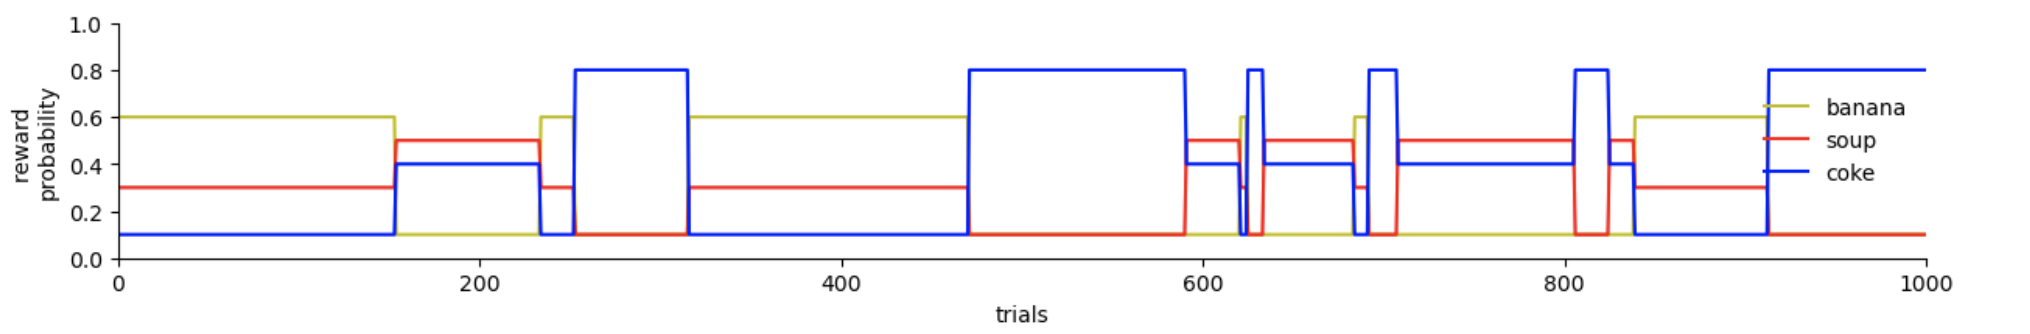

As a result, a subject will prefer one item for a few trials, then switch to another item after inferring the change in value, and switch again after a few trials. Hence, saccade endpoints will be dependent between trials.
To obtain insight into the subject's inference of the highest rewarded object, we will model the temporal dependency between trials explicitly using *hidden Markov models*. 

# 1. The Markov model as a generative model

We can understand Markov models as an extension of mixture models, where sample $n$ depends on sample $n-1$ (e.g. the previous trial). Like mixture models, Markov models have two classes of variables:

- **Latent variables** $\boldsymbol{z} \in \{0, 1\}^{K \times N}$, which indicate the class each sample belongs to. In hidden Markov models, $\boldsymbol{z}$ is often referred to as *state*.
- **Observations** $\boldsymbol{x}$, in our case $\boldsymbol{x} \in \mathbb{R}^{D \times N}$ (but observations could also be categorical). In hidden Markov models, $\boldsymbol{x}$ are also called the *emissions*. We will model Gaussian emissions $\boldsymbol{x} | \boldsymbol{z} \sim \mathcal{N}(\mu, \Sigma)$.

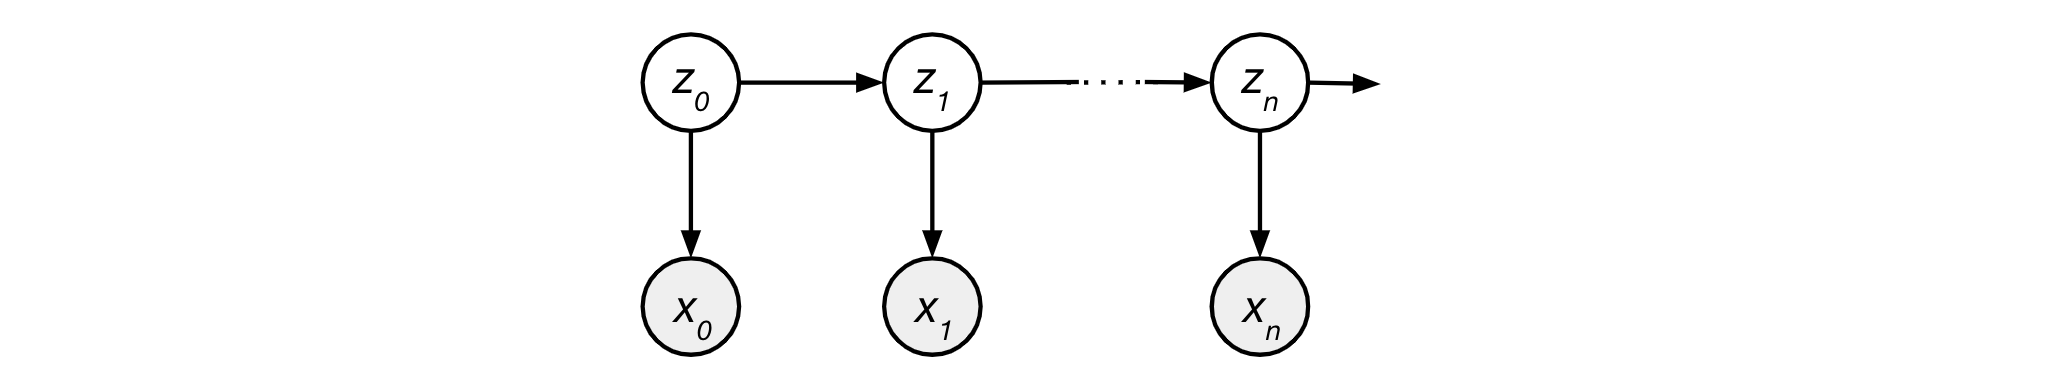

The sequential interdependency of latent variables is jointly described as a *Markov chain*

\begin{align}
p(\boldsymbol{z}_0, ..., \boldsymbol{z}_N) = p(\boldsymbol{z}_0) \prod_{n=1}^{N} p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1})
\end{align}

The joint distribution of latent and observed variables, given parameters $\theta$, is

\begin{align}
p(\boldsymbol{x}, \boldsymbol{z} | \theta) = p(\boldsymbol{x}_0, ..., \boldsymbol{x}_N, \boldsymbol{z}_0, ..., \boldsymbol{z}_N | \theta) = p(\boldsymbol{z}_0 | \theta) \prod_{n=1}^{N} p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}, \theta) \prod_{n=0}^{N} p(\boldsymbol{x}_n | \boldsymbol{z}_{n}, \theta)
\end{align}<div style="text-align: right"> Eq. (1) </div>

where 
- $p(\boldsymbol{x}_n | \boldsymbol{z}_n, \theta)$ are the *emission probabilities*, i.e. the likelihood that $\boldsymbol{x}_n$ was sampled from state $k$ encoded in $\boldsymbol{z}_n$ 
- $p(\boldsymbol{z}_0 | \theta)$ a vector of $k$ *initial state probabilities*, parametrized by $\pi_k$, 
- and $p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}, \theta)$ the *transition probabilities* between states in two adjacent samples. Since we need to know the probability to transition from any of $k$ states into any other state, transition probabilities are parametrized by a matrix $\boldsymbol{A} \in [0,1]^{K \times K}$, with $A_{jk} = p(z_{n,k}=1 | z_{n-1,j}=1)$ (rows sum to 1).

Sample an artificial dataset of 1000 trials from Eq. (1). Write a loop to first sample $\boldsymbol{z}$, and subsequently sample $\boldsymbol{x}$. Hyperparameters $K$ and $D$, as well as $\mu$, $\Sigma$, and $\pi$ are taken to be the same as in the Gaussian mixture model tutorial (but note that $\pi$ now has a slightly different interpretation).

## 1.1. Ground truth parameters 



In [2]:
# set random seed
np.random.seed(0)

# Hyperparameters
N = 1000
K = 3
D = 2

# screen borders
borders = np.array([[0,80], [0,60]])

# initial state probabilities
pis = [.2, .35, .45]

# transition probabilities - normalize rows to sum to 1
As = np.eye(K) + np.random.rand(K,K)/50
As = np.array([a/np.sum(a) for a in As])

# mus
mus = [np.array([20,20]), np.array([35,40]), np.array([60,25])]

# pick covariances - make symmetric with small covariance to ensure they are positive semidefinite
sigmas = [20*np.array([[1,-.4],[-.4,1]]), 
          40*np.array([[.5,0],[0,1]]), 
          40*np.array([[1,.1],[.1,1]])]

## 1.2. True value of latent variable $\boldsymbol{z}$

In [3]:
# sample initial state

# sample state sequence in a loop, with probabilities taken from row k of matrix A

# make K x N array for true values of z


Plot the sequence of states over time.

Text(0.5, 0, 'trial')

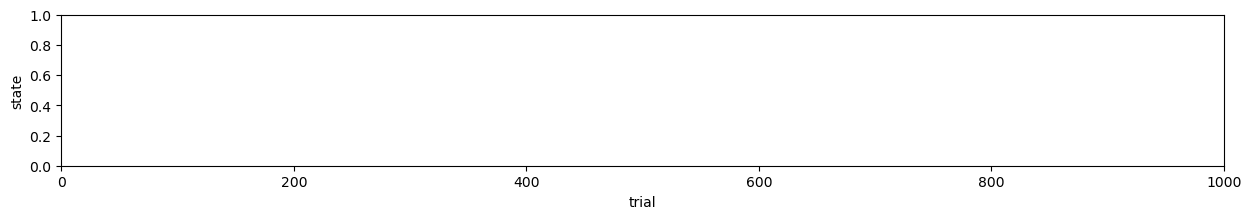

In [4]:
plt.figure(figsize=(15,2), dpi=100)
# plt.plot(ks, 'k-')
plt.xlim(0,N)
plt.ylabel('state')
plt.xlabel('trial')

## 1.3. Sample observations $\boldsymbol{x}$

Sample observations from a multivariate Gaussian as in the previous tutorial. Uncomment the respective lines to plot saccade data across trials in the 2D space of observations.

In [5]:
# simulate saccades depending on k_n


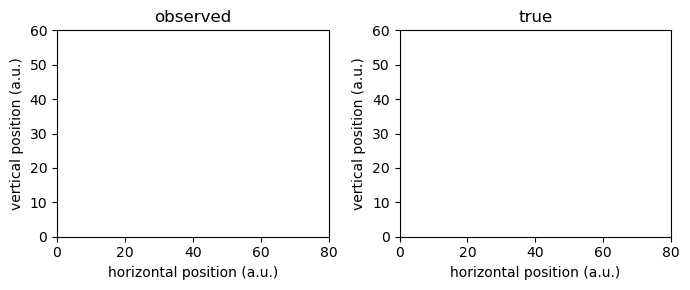

In [6]:
# plot data
colors = ['y', 'r', 'b']

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
# plt.scatter(saccades[:,0], saccades[:,1], c='k', alpha=.05)
# plt.plot(saccades[:,0], saccades[:,1], 'k-', alpha=.1)
# for mi,m in enumerate(mus):
#     plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('observed')

plt.subplot(1,2,2)
# plt.scatter(saccades[:,0], saccades[:,1], c=[colors[k] for k in ks], alpha=.05)
# plt.plot(saccades[:,0], saccades[:,1], 'k-', alpha=.1)
# for mi,m in enumerate(mus):
#     plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('true')
plt.tight_layout()

# 2. Fitting hidden Markov models with EM

To the experimenter of our eye tracking experiment, the values of the latent variable $\boldsymbol{z}$ are unobserved or *hidden* - this is how a Markov model becomes a hidden Markov model. As before, we assume $K = 3$ as fixed to its true value, and emissions to be Gaussian.

Our inference problem thus concerns:
- the value of the hidden variable, $z_n$, for observation $x_n$
- parameters $\theta = \{\mu, \Sigma, \pi, \boldsymbol{A}\}$.

Similar to the inference process in the mixture of Gaussians, we are going to employ the EM algorithm to iteratively infer expected values of the latent distribution and the parameters $\theta$. As you will see in the following, the E step is slightly more complicated than in standard mixture models, due to the sequential dependency of $\boldsymbol{z}$.

## 2.1. Initialization

Write a function to pick random values for the parameters (within sensible bounds; you can re-use code from the previous tutorial). 

Initialize $\boldsymbol{A}$ as a $K \times K$ identity matrix and add some noise. Keep in mind that all elements $A_{jk}\ge 0$. Normalize rows of $\boldsymbol{A}$ as well as the initial state probabilities $\pi$.

In [7]:
# function to initialize the HMM
def initialize_HMM(K, D, lower, higher):
    
    # mu: initialize means to random integers
    
    # Sigma: initialize covariance to random integer on diagonal, 0 off-diagonal

    
    # pi: pick random numbers that sum to 1

    # A: Identity plus random numbers, rows should sum to 1
    
    return m, s, p, A

In [8]:
# call initialization


## 2.2. Evaluation of log likelihoods

The likelihood $p(\boldsymbol{x}_n | z_{nk}=1, \theta)$ plays a central role in telling us how likely each sample is under a class- (or state-)specific model. We have used the likelihood in the mixture model tutorial (in the E Step, as well as for the evaluation of the expected complete-data log likelihood), but we have never visualized what this quantity tells us about the data.

To do so, evaluate the log likelihood $\ln p(\boldsymbol{x}_n | z_{nk}=1, \theta)$ for each sample $n$. The resulting array should have shape $K \times N$: It encodes the likelihood of sample $n$ belonging to state $k$. 

Use the pre-coded plotting function to plot the probability density for each state, as well as the saccades, color-coded by the log likelihood you computed. 

In [9]:
# evaluate log likelihood for each datapoint


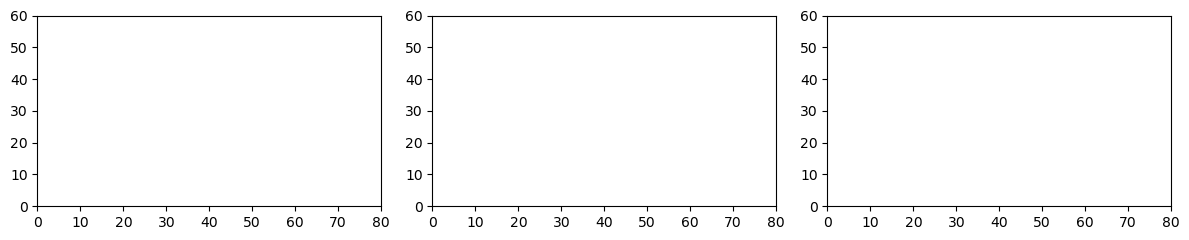

In [10]:
# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x,y))

# evaluate pdf at grid 


plt.figure(figsize=(12,2.5), dpi=100)
for k in range(K):
    plt.subplot(1,3,k+1)
#     plt.contour(pdfs[k].T, colors='k')
#     plt.scatter(saccades[:,0], saccades[:,1], c=log_likes[k], cmap='magma', vmin=-50, vmax=-5)
#     plt.title(r'$\mu_k = [%.0f, %.0f]$' %(m[k][0], m[k][1]))
    plt.xlim(0,80)
    plt.ylim(0,60)
#     plt.colorbar(label= r'$\ln p(x_n | z_{nk}=1, \theta_k)$')
plt.tight_layout()

## 2.3. E Step

As in the last tutorial, we are interested in inferring the posterior distribution of the latent variable and its expected values, which are then used to find optimal parameters that maximize the complete-data log likelihood in the M Step. Since our latent variable $\boldsymbol{z}$ is *not i.i.d.*, but has temporal interdependencies (as you can see from the graph and Eq. (1)), two pieces of information about the posterior distribution are of interest: 
- The expected probability of observing state $k$ at trial $n$, $\gamma(z_{nk}) = \mathbb{E}_z[z_{nk}]$
- the expected probability of observing state $k$ in trial $n$, after having observed state $j$ in trial $n-1$, $\xi(z_{n-1,j},z_{nk}) = \mathbb{E}_z[z_{n-1,j}z_{nk}]$.

### 2.3.1. Marginal posterior $\gamma$

We can use Bayes theorem to calculate the former, which is also called the marginal posterior $\gamma(z_n) = p(\boldsymbol{z}_n | \boldsymbol{x}, \theta)$ (dropping $\theta$ to keep this uncluttered):

\begin{align}
p(\boldsymbol{z}_n | \boldsymbol{x}) &= \frac{p(\boldsymbol{x} | \boldsymbol{z}_n) p(\boldsymbol{z}_n)}{p(\boldsymbol{x})} \\
&= \frac{p(\boldsymbol{x}_{0:n} | \boldsymbol{z}_n) p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n) p(\boldsymbol{z}_n)}{p(\boldsymbol{x})} \\
\end{align} 

where we separate $p(\boldsymbol{x} | \boldsymbol{z}_n)$ into two terms, $p(\boldsymbol{x}_{0:n} | \boldsymbol{z}_n)$ and $p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n)$. We can do this because observations $\boldsymbol{x}_{0:n}$ and $\boldsymbol{x}_{n+1:N}$ are conditionally independent, given $\boldsymbol{z}_{n}$, as shown in this graph: 

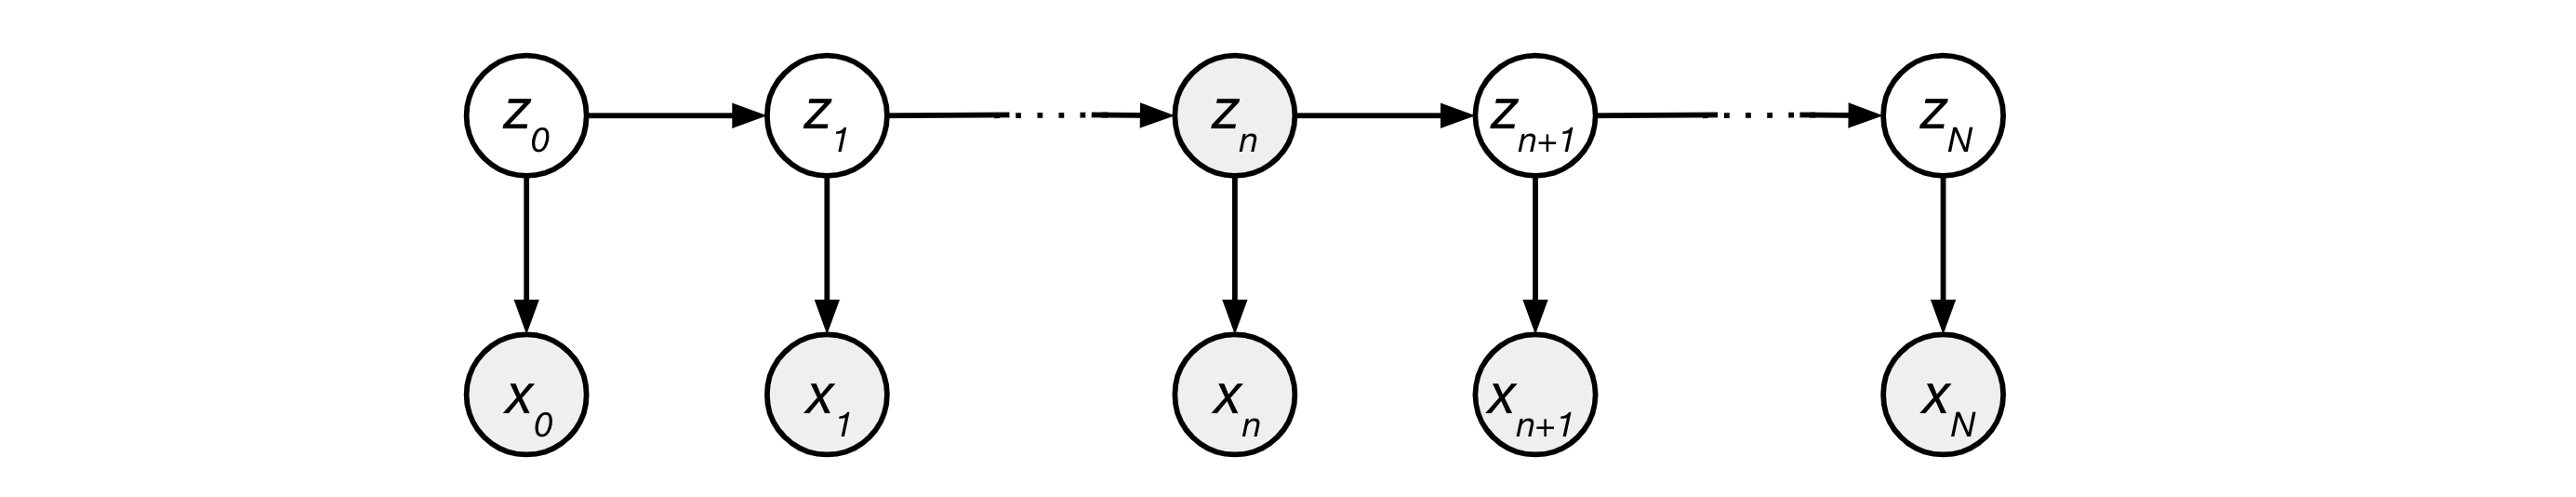

Moreover, we introduce *forward messages* $\alpha(\boldsymbol{z}_n) = p(\boldsymbol{x}_{0:n} | \boldsymbol{z}_n) p(\boldsymbol{z}_n) = p(\boldsymbol{x}_{0:n}, \boldsymbol{z}_n)$ and *backward messages* $\beta(\boldsymbol{z}_n) = p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n)$, so that:

\begin{align}
p(\boldsymbol{z}_n | \boldsymbol{x}) &= \frac{\alpha(\boldsymbol{z}_n) \beta(\boldsymbol{z}_n)}{p(\boldsymbol{x})} 
\end{align} <div style="text-align: right"> Eq. (2) </div>

### 2.3.2. Joint posterior $\xi$

Similarly, we can calculate the joint posterior $\xi(z_n,z_{n-1}) = p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}, \theta)$ (again omitting $\theta$ and skipping intermediate steps of the derivation):

\begin{align}
p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}) &= \frac{p(\boldsymbol{x} | \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n}) p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})}{p(\boldsymbol{x})} \\
&= \frac{\alpha(\boldsymbol{z}_{n-1}) p(\boldsymbol{x}_n | \boldsymbol{z}_n) p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}) \beta(\boldsymbol{z}_n)}{p(\boldsymbol{x})} 
\end{align} <div style="text-align: right"> Eq. (3) </div>

To calculate $\alpha(\boldsymbol{z}_n)$ and $\beta(\boldsymbol{z}_n)$, we use a recurrent algorithm, called the *forward-backward algorithm* (also called Baum-Welch algorithm).

### 2.3.3. Forward-backward algorithm

*Forward messages* $\alpha(\boldsymbol{z}_n) = p(\boldsymbol{x}_{0:n}, \boldsymbol{z}_n)$ tell us for each trial $n$ the probability of being in state $\boldsymbol{z}_n$, given that we have seen the sequence of obervations $\boldsymbol{x}_{0:n}$. *Backward messages* $\beta(\boldsymbol{z}_n) = p(\boldsymbol{x}_{n+1:N} | \boldsymbol{z}_n)$ look ahead in time: What would be the probability of *future* observations $\boldsymbol{x}_{n+1:N}$, if we started from each of the states $\boldsymbol{z}_n$ in trial $n$.

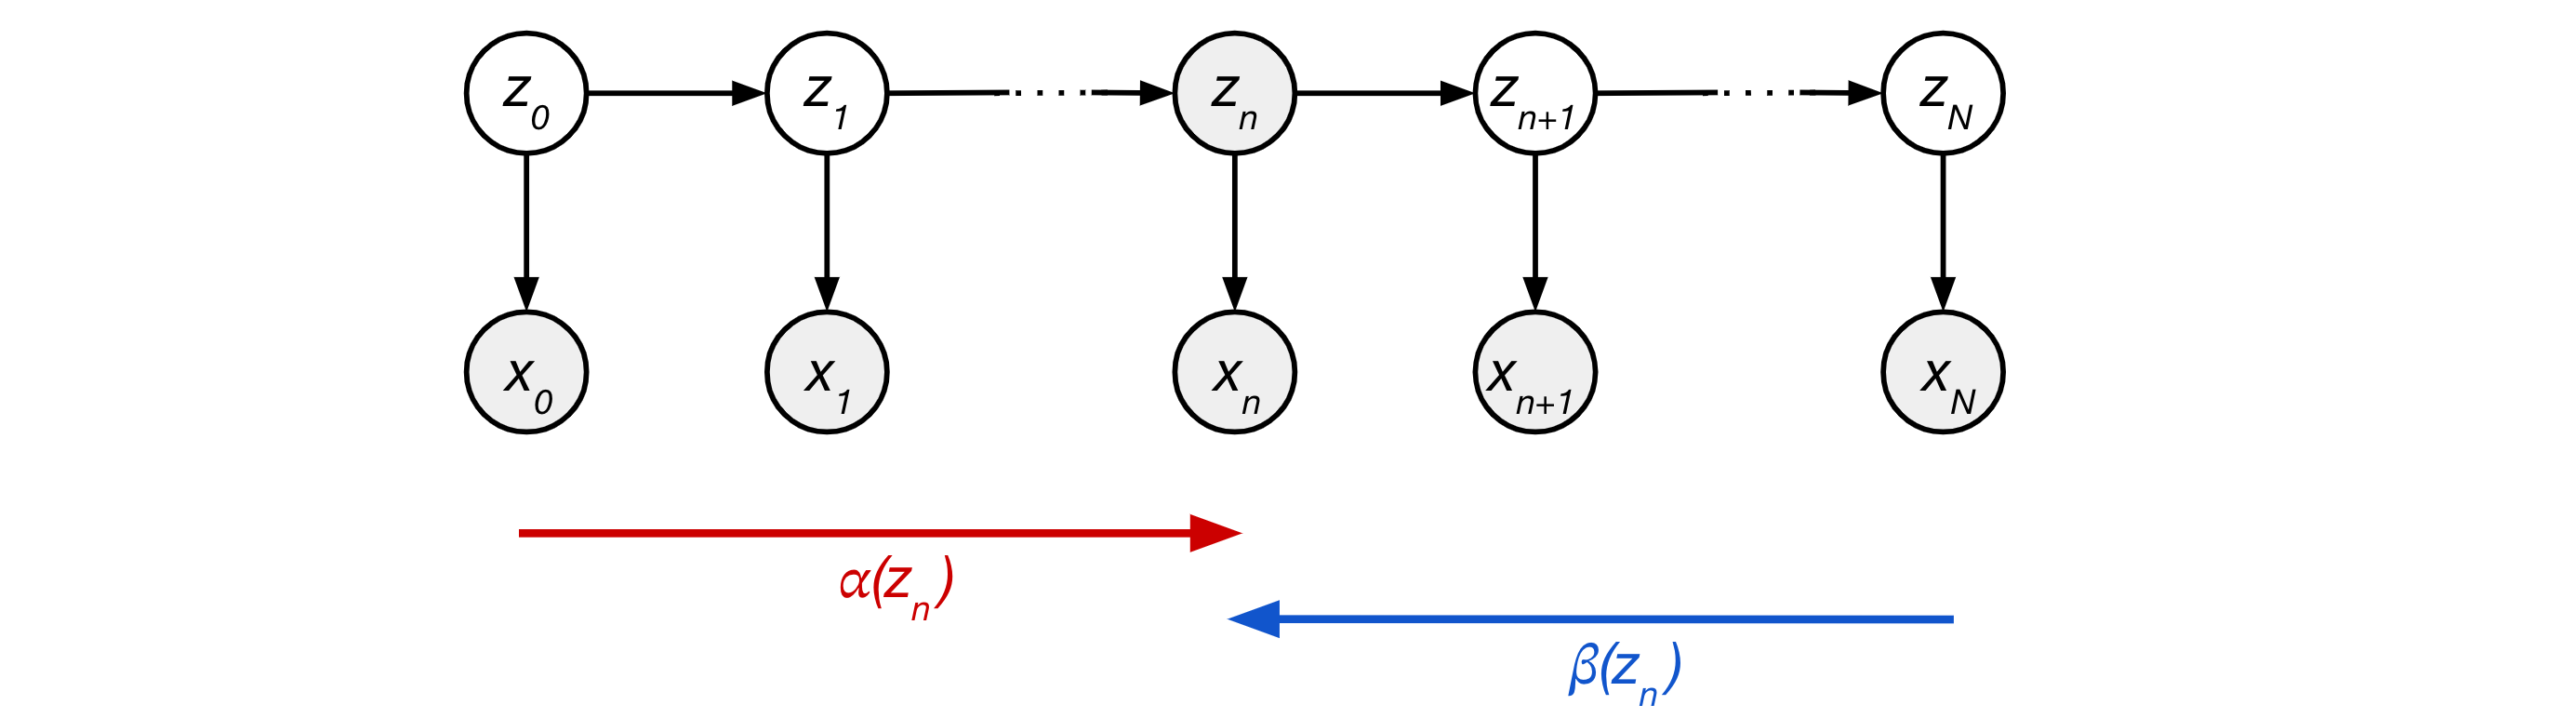

The forward-backward algorithm takes advantage of a number of conditional independence properties to express $\alpha(\boldsymbol{z}_n)$ as a function of $\alpha(\boldsymbol{z}_{n-1})$, and  $\beta(\boldsymbol{z}_n)$ as a function of $\beta(\boldsymbol{z}_{n+1})$. The idea is that $\alpha(\boldsymbol{z}_0)$ and $\beta(\boldsymbol{z}_N)$ are easy to determine, and that by only calculating an adjacent term at a time, we can break the difficult problem of calculating a joint probability over many samples into a set of simpler problems (each involving only two adjacent sample at a time).

Hence, we'll have to calculate $\alpha(\boldsymbol{z}_0)$ and $\beta(\boldsymbol{z}_N)$ and then iterate forward or backward in time. For the sake of time, we implemented these equations for you in the `hmm_library`, commenting on what each line does - no need to look at it now.

#### Forward messages

We calculate forward messages as

\begin{align}
\alpha(\boldsymbol{z}_0) &= p(\boldsymbol{z}_0)p(\boldsymbol{x}_0 | \boldsymbol{z}_0)  \\
\alpha(\boldsymbol{z}_n) &= p(\boldsymbol{x}_n | \boldsymbol{z}_n) \sum_{z} \{\alpha(\boldsymbol{z}_{n-1})p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1})\} 
\end{align}

Note that we will again calculate log-transformed values $\ln \alpha(\boldsymbol{z}_n)$, since they are easier to work with. 
Call `log_alphas = hmmlib.forward(p, A, log_likes)` to get log-transformed forward messages.

In [11]:
# call forward algorithm


#### Backward messages

Then, we call `log_betas = hmmlib.backward(A, log_likes)` to calculate log-transformed backward messages $\ln \beta(\boldsymbol{z}_n)$, where

\begin{align}
\beta(\boldsymbol{z}_N) &= 1 \\
\beta(\boldsymbol{z}_n) &= \sum_{z} \beta(z_{n+1}) p(\boldsymbol{x}_{n+1} | \boldsymbol{z}_{n+1}) p(\boldsymbol{z}_{n+1} | \boldsymbol{z}_n)
\end{align}

The initial value is taken to be 1, so that $p(\boldsymbol{z}_N | \boldsymbol{x}) = \frac{p(\boldsymbol{z}_N, \boldsymbol{x}) \beta(\boldsymbol{z}_N)}{p(\boldsymbol{x})}$ is properly normalized. Call `log_betas = hmmlib.backward(A, log_likes)` to get log-transformed backward messages.

In [12]:
# call backward algorithm


### 2.3.4. Calculate expected states: marginal posterior $\gamma$

Write a function that implements Eq. (2) to calculate expected values of the posterior $\gamma(z_n) = p(\boldsymbol{z}_n | \boldsymbol{x})$ from $\alpha(\boldsymbol{z}_n)$ and $\beta(\boldsymbol{z}_n)$. For reference, here we have Eq. (2) written out in a slightly different way:

\begin{align}
p(\boldsymbol{z}_n | \boldsymbol{x}) 
= \frac{p(\boldsymbol{x} | \boldsymbol{z}_n) p(\boldsymbol{z}_n)}{p(\boldsymbol{x})}
= \frac{{p(\boldsymbol{x}, \boldsymbol{z}_n)}}{\sum_{\boldsymbol{z}} p(\boldsymbol{x}, \boldsymbol{z}_n)} 
= \frac{\alpha(\boldsymbol{z}_n) \beta(\boldsymbol{z}_n)}{\sum_{\boldsymbol{z}} \alpha(\boldsymbol{z}_n) \beta(\boldsymbol{z}_n)} 
\end{align}


<!-- *Hint*: From Eq. (2), we see that we can express the marginal likelihood $p(\boldsymbol{x})$ as the likelihood of observing a sequence up to trial $n$: $p(\boldsymbol{x}_{0:n}) = \sum_z p(\boldsymbol{x}_{0:n}, \boldsymbol{z}_n) = \sum_K \alpha(z_{nk})$. -->

Plot $\gamma(z_{n})$ over trials.

In [13]:
def expected_states(log_alphas, log_betas):

    # upper: alpha * beta --> becomes log_alpha + log_beta
    
    # subtract log of the sum over states of log_alpha + log_beta
    
    # transform back by taking exp
    
    return gammas

In [14]:
# call expected states function


Text(0.5, 0, 'trial')

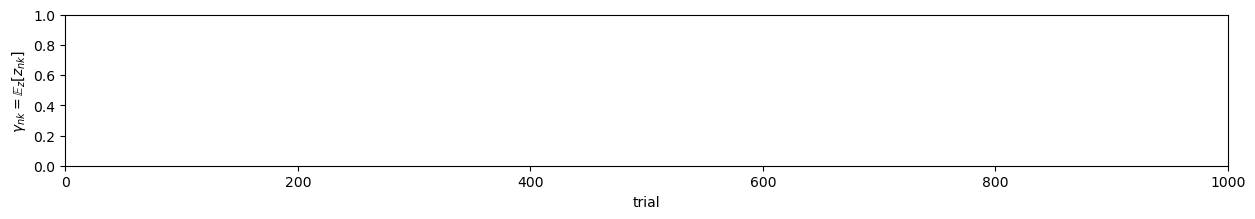

In [15]:
# plot gammas over the course of trials
plt.figure(figsize=(15,2), dpi=100)

# for k,g in enumerate(gammas.T):
#     plt.plot(g, color=colors[k])
plt.xlim(0,N)
plt.ylabel(r'$\gamma_{nk} = \mathbb{E}_z[z_{nk}]$')
plt.xlabel('trial')

### 2.3.5. Calculate expected transitions: Joint posterior $\xi$

Analogously, we can calculate expected values of the joint posterior $\xi(z_n,z_{n-1}) = p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}, \theta)$ from Eq. (3) (again omitting $\theta$):

\begin{align}
p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_n | \boldsymbol{x}) 
= \frac{p(\boldsymbol{x} | \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n}) p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})}{p(\boldsymbol{x})}
= \frac{p(\boldsymbol{x}, \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})}{\sum_{\boldsymbol{z}_n}\sum_{\boldsymbol{z}_{n-1}} p(\boldsymbol{x}, \boldsymbol{z}_{n-1}, \boldsymbol{z}_{n})} 
= \frac{\alpha(\boldsymbol{z}_{n-1}) p(\boldsymbol{x}_n | \boldsymbol{z}_n) p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}) \beta(\boldsymbol{z}_n)}{\sum_{\boldsymbol{z}_n}\sum_{\boldsymbol{z}_{n-1}} \alpha(\boldsymbol{z}_{n-1}) p(\boldsymbol{x}_n | \boldsymbol{z}_n) p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}) \beta(\boldsymbol{z}_n)} 
\end{align}, 

where $p(\boldsymbol{x}_n | \boldsymbol{z}_n, \theta)$ is the likelihood that data point $\boldsymbol{x}_n$ under any of the $k$ states encoded by $z_n$, and $p(\boldsymbol{z}_n | \boldsymbol{z}_{n-1}, \theta)$ are transition probabilities stored in $\boldsymbol{A}$.

Call `hmmlib.expected_transitions(log_alphas, log_betas, log_likes, A)` to calculate expected values $\xi(z_n,z_{n-1})$ of the joint posterior.

In [16]:
# calculate expected transitions


### 2.3.6. Full E Step

Write a function `HMM_estep(p, As, log_likes)` that calls `forward`, `backward`, `expected_states` and `expected_transitions` and returns $\gamma(z_{nk}) \in [0,1]^{T \times K}$ and $\xi(z_{n-1,k}, z_{n,j}) \in [0,1]^{T \times K \times K}$, as well as the log likelihood.

***Hint:*** In hidden Markov models, the likelihood $p(\boldsymbol{x}) = p(\boldsymbol{x}_N)$ comes for free from the forward-backward algorithm. Eq. (2) as written out in section 2.3.4. will tell you how to calculate it.

In [17]:
def HMM_estep(p, As, log_likes):
    
    # forward pass
    
    # backward pass
    
    # calculate posterior: expected states
    
    # calculate posterior: expected transitions
    
    # calculate log likelihood
    
    return gammas, xis, log_LL

In [18]:
# call E step


## 3. M Step

After this longish E Step, the good news are that the M Step is more straightforward.

As in the previous tutorial, it consists of plugging in $\gamma(z_{nk})$ and $\xi(z_{n-1,k}, z_{nj})$ in the expected complete-data log likelihood $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$ from Eq. (1). We then derive it w.r.t. each of the model parameters $\theta = \{\mu, \Sigma, \pi, A\}$ (we'll spare you the math excercise). Setting these derivatives to zero leads to closed-form solutions for ML parameter updates as in the mixture model tutorial.

The resulting solutions for each of the parameters are:

\begin{align}
\mu_k &= \frac{\sum_N \gamma(z_{nk})\boldsymbol{x}_n}{\sum_N \gamma(z_{nk})} \\
\end{align}<div style="text-align: right"> Eq. (4) </div>
\begin{align}
\Sigma_k &= \frac{\sum_N \gamma(z_{nk})(\boldsymbol{x}_n -\mu_k)(\boldsymbol{x}_n -\mu_k)^T}{\sum_N\gamma(z_{nk})} \\
\end{align}<div style="text-align: right"> Eq. (5) </div>
\begin{align}
\pi_k = \frac{\gamma(z_{0,k})}{\sum_K \gamma(z_{0,j})}
\end{align}<div style="text-align: right"> Eq. (6) </div>
\begin{align}
A_{jk} = \frac{\sum_N \xi(z_{n-1,j}, z_{nk})}{\sum_K \sum_N \xi(z_{n-1,j}, z_{nl})}
\end{align}<div style="text-align: right"> Eq. (7) </div>

Write a function `HMM_mstep(data, gammas, xis)` that implements Eqs. (4-7) and returns the updated parameters. If you are stuck, look at the M step as pre-coded in the library.

In [19]:
def HMM_mstep(data, gammas, xis):
    K = gammas.shape[1]
    N = gammas.shape[0]
    D = data.shape[-1]
    
    # class-specific normalization constant
    
    # mu
    
    # Sigma
    
#     for k in range(K):

        # ... (insert code here)

        # in case that only one data point is assigned to a class, we get zero variance, so
        # re-initialize sigma to avoid problems with evaluation of pdf
        
        # (uncomment the following lines)
#         if np.sum(s[k]==0, axis=(0,1))==D**2:
#             print('re-initialize sigma')
#             s[k] = np.array([[10,0],[0,10]])

    # pi
    
    # A
        
    return m, s, p, A

In [20]:
# call M Step


## 4. full EM for hidden Markov models

We now have all necessary code elements to run a full iteration of EM for the HMM. Write a code that 0) initializes parameters $\theta = \{\mu, \Sigma, \pi, A\}$, 1) performs the E Step and then 2) the M Step. Iterate over 1) and 2) 50 times. 

Repeat the procedure with 5 different random initializations. Save log likelihoods and model parameters for each repetition and pick the best model.

In [21]:
model = []; LLs = []

# iterate 5 times
    
    # 0: initialization
    
    # iterate 50 times
        
        # evaluate log likelihoods 
        
        # 1: E Step
        
        # 2: M step
        

## 4.1. Learning curves

Plot likelihood curves over learning to check model convergence.

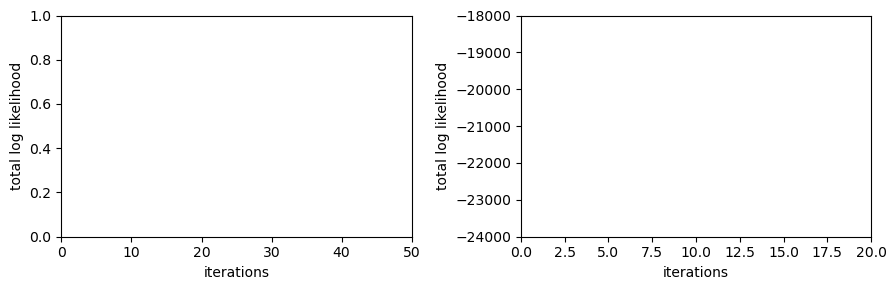

In [22]:
# plot log likelihoods for all random initializations to check if model converged
plt.figure(figsize=(9,3), dpi=100)
plt.subplot(1,2,1)
# plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.subplot(1,2,2)
# plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,20)
plt.ylim(-24000, -18000)
plt.tight_layout()

## 4.2. Visualize best model

Pick the best model and plot the Gaussian distribution for each of the three states. Compare (qualitatively) to the ground truth. 

In [23]:
# select best model


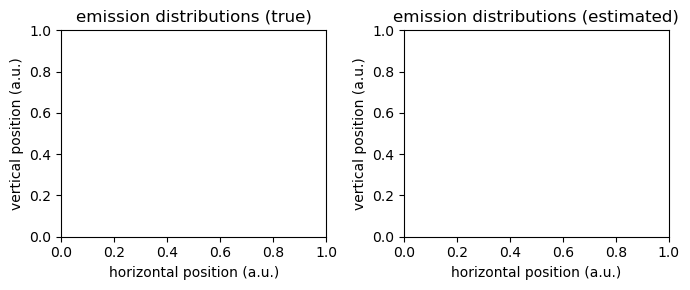

In [24]:
# plot final means and covariances, as well as final mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs

# true pdfs

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
# for k,pdf in enumerate(pdfs_true):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('emission distributions (true)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,2,2)
# for k,pdf in enumerate(pdfs):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('emission distributions (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

# 3. Decoding the optimal sequence: Viterbi algorithm

In the hidden Markov model, we are often interested in classifying data points as belonging to one state or another. In our example, we would like to know which object a subject was looking at in each trial. Counter-intuitively, we cannot just pick the state with the highest $\gamma(\boldsymbol(z))_{nk}$ for each trial, but have to consider the whole sequence of states together.

Since from each state $k_n$, we can go to any state $k_{n+1}$, and from there to any other state $k_{n+2}$ and so forth, there will be $K \times K \times  K ...$, i.e., $K^N$, potential sequences.

The *Viterbi algorithm* is a smart way of tackling this problem iteratively: It will determine the most likely state in each trial $n$, based on a combination of the likelihood $p(\boldsymbol{x}_n | \boldsymbol{x}_n, \theta)$, the most likely state in trial $n-1$, and the transition probabilities from trial $n-1$ to trial $n$.

We have pre-coded the Viterbi algorithm for you. It works with log probabilities, and will return a sequence of values that you can directly compare to the ground truth sequence of `ks`. 

Evaluate the log likelihoods under the best model, and pass it to `hmmlib.log_viterbi(log_likes, A, p)`, together with $A$ and $\pi$. Plot the fitted sequence vs. the true sequence of states.

In [25]:
# evalualte log likelihoods under the best model

# call log viterbi


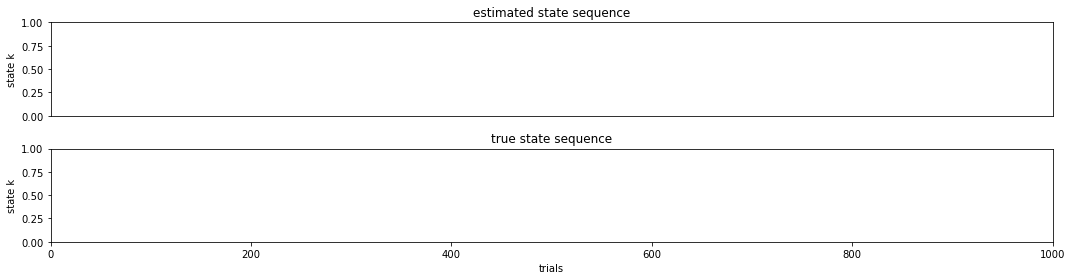

In [26]:
plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
# plt.plot(seq, 'k')
plt.title('estimated state sequence')
plt.xlim(0,1000)
plt.xticks([])
plt.ylabel('state k')
plt.subplot(2,1,2)
# plt.plot(ks, 'k', label='true')
plt.title('true state sequence')
plt.xlim(0,1000)
plt.xlabel('trials')
plt.ylabel('state k')
plt.tight_layout()